# Setup

In [2]:
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path

%matplotlib inline

# Explore the RI Volume

Although the data range of raw RI volume is [1.337, 1.39], volumes in the testset directory are normalized to [0.0, 1.0] for numerical stability. Each volume is sized of [80, 512, 512] for [depth, height, width], repectively.

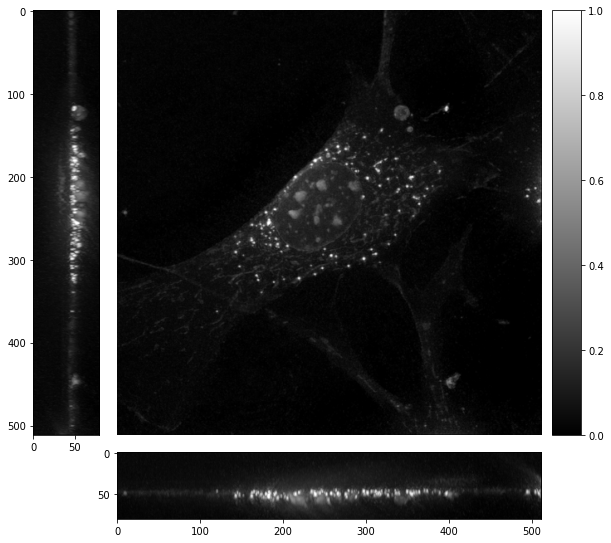

In [8]:
def plot(img, figsize=(10, 10), cmap="gray"):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(img.max(0), cmap=cmap)
    ax.axis("off")
    ax.set_aspect(1.)

    divider = make_axes_locatable(ax)
    ax_yz = divider.append_axes("left", 1.2, pad=0.1, sharey=ax)
    ax_xz = divider.append_axes("bottom", 1.2, pad=0.1, sharex=ax)
    ax_cb = divider.append_axes("right", 0.4, pad=0.15)

    ax_yz.imshow(img.max(2).T, cmap=cmap)
    ax_xz.imshow(img.max(1), cmap=cmap)
    plt.colorbar(im, cax=ax_cb)

img_path = list(Path("testset").rglob("*.h5"))[0]
with h5py.File(img_path, "r") as h:
        ri = h["ri"][()]
plot(ri, (10, 10))

# Make setup script
`Ri2Fl` parses arguments from the `yaml_file`.

In [4]:
import yaml

arguments = {}
paths = dict(dataset="testset", model_path="models", save_path="result_")
setup = dict(
    fl_list="mem",
    batch_size=4,
    gpus="7",
    cpus=4,
    zoomed_size=[512, 512],
    patch_size=256,
    cropped_depth=64,
    num_drop=0,
    num_tta=4,
)
arguments["paths"] = paths
arguments["setup"] = setup

with open('scripts/setup.yaml', 'w') as f:
    yaml.safe_dump(arguments, f)

# Load setups from the `yaml_file`

In [7]:
with open(r"scripts/setup.yaml") as h:
    args = yaml.safe_load(h)

print(args)
paths = args["paths"]
setup = args["setup"]

{'paths': {'dataset': 'testset', 'model_path': 'models', 'save_path': 'result_'}, 'setup': {'batch_size': 4, 'cpus': 4, 'cropped_depth': 64, 'fl_list': 'mem', 'gpus': '7', 'num_drop': 0, 'num_tta': 4, 'patch_size': 256, 'zoomed_size': [512, 512]}}


# Preparing Data for Inference

Due to the nature of patch-based inference mechanism, `Ri2Fl` requires $64 \times 256 \times 256$ patches as an input.

`SlideDataset` performs `loading an image`, `resizing`, `padding`, and `patching`.

It returns `tuple` of `[patch, coordinate, file_name]`.

In [9]:
from torch.utils.data import DataLoader
from loaders.slideloader import SlideDataset

dataset = SlideDataset(
    path=img_path,
    zoomed_size=setup["zoomed_size"],
    patch_size=setup["patch_size"],
    cropped_depth=setup["cropped_depth"],
)
loader = DataLoader(dataset, batch_size=setup["batch_size"], pin_memory=True)

# Load the Serialized model and Predict fluorescent images for input patches

In [11]:
import torch

model = torch.jit.load(f"{paths['model_path']}/{setup['fl_list']}.pth").cuda()

with torch.no_grad():
    for img, coord, name in loader:
        img = img.cuda()
        output = model(img)

        for i in range(output.size(0)):
            f = name[i]
            c = coord[i].numpy()
            o = output[i].cpu().numpy()[0]

            patches = {f"fl_{setup['fl_list']}": o}

            def save_h5(name, coord, patch):
                Path(name).parent.mkdir(parents=True, exist_ok=True)
                with h5py.File(name, "a") as h:
                    dst = h.create_group(f"{coord[0]}_{coord[1]}")
                    for k, v in patch.items():
                        dst.create_dataset(k, data=v)

            try:
                save_h5(f"{paths['save_path']}/{f}.h5", c, patches)
            except ValueError:
                pass

# Visualize inferred patches

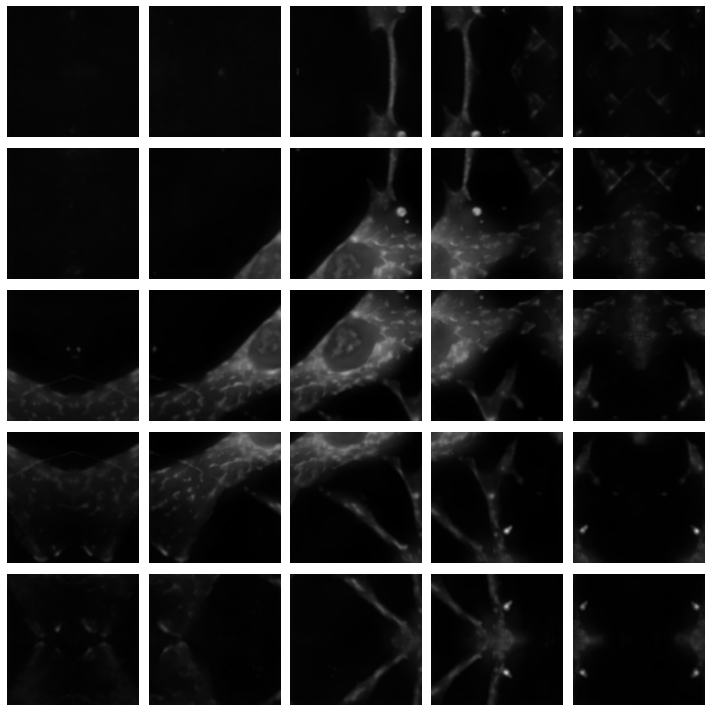

In [19]:
def multirow_plot(img_dict, figsize=(10, 10), cmap="gray"):
    plt.figure(figsize=figsize)
    for row in range(5):
        for col in range(5):
            ax = plt.subplot(5, 5, col + 1 + row * 5)
            plt.axis("off")
            coord = f"{row * 128}_{col * 128}"
            fl_type = f"fl_{setup['fl_list']}"
            img = img_dict[f"{coord}/{fl_type}"][()].max(0)
            plt.imshow(img, cmap=cmap, vmin=0, vmax=1)
    plt.tight_layout()
    plt.show()    

with h5py.File("result_/0.h5", "r") as h:
    multirow_plot(h)

# Stitch the output patches

In [20]:
from utils.stitcher import Stitcher2d

stitcher = Stitcher2d(
    depth=setup["cropped_depth"],
    patch_size=setup["patch_size"],
    zoomed_size=setup["zoomed_size"][0],
    post_op=lambda x: x,
)

patches = {}
infer_list = list(Path(f"{paths['save_path']}").rglob("*.h5"))
for p in infer_list:
    with h5py.File(p, "a") as h:
        for c, imgs in h.items():
            if isinstance(imgs, h5py.Group):
                y, x = c.split("_")
                c_ = torch.tensor([int(y), int(x)], dtype=torch.int16)
                patches[c_] = imgs
        img = stitcher.stitch(patches)

        for k, v in img.items():
            try:
                data = (v - v.min()) / (v.max() - v.min())
                h.create_dataset(k, data=data)
            except RuntimeError:
                pass

        for k, v in h.items():
            if isinstance(v, h5py.Group):
                del h[k]

# Visualize stitched output

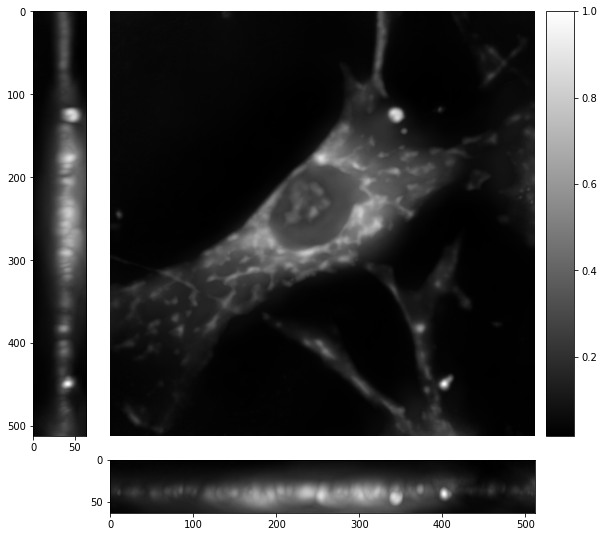

In [23]:
with h5py.File("result_/0.h5", "r") as h:
    fl = h[f"fl_{setup['fl_list']}"][()]

plot(fl)